In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def create_numerics(data):
    # Get nominal columns
    nominal_cols = data.select_dtypes(include='object').columns.tolist()

    # Turn nominal to numeric
    for nom in nominal_cols:
        enc = LabelEncoder()
        enc.fit(data[nom])
        data[nom] = enc.transform(data[nom])

    return data

In [38]:
def prepare_data():
    data = pd.read_excel("HEROdata2.xlsx")
    data = data.dropna()
    
    trojan_free = data.loc[data['Label']=="'Trojan Free'"].reset_index()    
    
    # balance the ratio between trojan free and infected of the same circuit category
    for i in range(len(trojan_free)):
        category_substring = trojan_free['Circuit'][i].replace("'",'')
        circuit_group = data[data['Circuit'].str.contains(category_substring)]
        
        df1 = circuit_group.iloc[0:1]
        
        if len(circuit_group) > 1:
            data = data.append([df1]*(len(circuit_group)-1), ignore_index=True)
    
    data.drop(columns=['Circuit'], inplace=True)

    data = create_numerics(data)
    
    data = shuffle(data, random_state=42)

    # Create correlation matrix
    corr_matrix = data.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                      k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    # Drop features
    data = data.drop(data[to_drop], axis=1)
    
    y = pd.DataFrame(data["Label"]).values
    x = data.drop(["Label"], axis=1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    x = scaler.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

    # plot the correlated features
    sns.heatmap(
        corr_matrix,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    plt.title("Features correlation")
    plt.show()
    return(x_train, x_test, y_train, y_test)

In [23]:
import time
import sys
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import np_utils as npu


In [ ]:
# !pip install xgboost

In [24]:
def create_model(train_x, test_y):
    num_classes = test_y.shape[1]

    model = Sequential()

    model.add(Dense(15, input_dim=train_x.shape[1], activation='relu'))

    model.add(Dense(75, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['mse', 'accuracy'])
    return model


In [25]:
def multilayer_perceptron():
    """
    This function performs multiclass classification with multilayer_perceptron
    """
    train_x, test_x, train_y, test_y = prepare_data()

    labels = test_y

    train_y = npu.to_categorical(train_y)
    test_y = npu.to_categorical(test_y)
    
    model = create_model(train_x, test_y)
    
    start = time.time()
    model.fit(train_x, train_y, epochs=50, batch_size=10, shuffle=False)
    end = time.time()
    
    y_pred = model.predict(test_x)
    predictions = np.argmax(y_pred, axis=1)

    correct_class = 0
    for i in range(len(labels)):
        if labels[i] == predictions[i]:
            correct_class += 1

    time_ = end - start
    accuracy = (correct_class / len(labels)) * 100

    print("### MLP ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    return(time_, accuracy)

In [26]:
def xgboost():
    """
    This function performs classification with XGBoost
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))
    
   
    clf = XGBClassifier(n_estimators=20)
    
    start = time.time()
    clf.fit(train_x, train_y)
    end = time.time()
    
    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### XGB ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    return(time_, accuracy)


In [27]:
def logistic_regression():
    """
    This function performs classification with logistic regression.
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))

    clf = LogisticRegression(random_state=0, solver='liblinear', max_iter=300,
                             multi_class='ovr')
    start = time.time()
    clf.fit(train_x, train_y)
    end = time.time()
    
    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### LR ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    return(time_, accuracy)

In [28]:
def random_forest():
    """
    This function performs classification with random forest.
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))
        
    clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=1)
    
    start = time.time()
    clf.fit(train_x, train_y)    
    end = time.time()

    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### RF ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))
    print("F1-score = ",f1_score(test_y, y_pred, average='macro')*100)
        
    """
    importance = clf.feature_importances_
    
    # summarize feature importance
    for i,v in enumerate(importance):
    	print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.xlabel('Features')
    plt.ylabel('Feature importance factor')
    plt.title('Features importance')
    plt.show()
    """
    return(time_, accuracy)



In [29]:
def k_neighbors():
    """
    This function performs classification with k neighbors algorithm.
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))
          
    clf = KNeighborsClassifier(n_neighbors=3)
    
    start = time.time()
    clf.fit(train_x, train_y)
    end = time.time()

    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### KNN ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    return(time_, accuracy)

In [30]:
def plot_confusion_matrix(cm, target_names, title, cmap=None, normalize=False):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [39]:
def gradient_boosting():
    """
    This function performs classification with Gradient Boosting.
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))
        
    clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=75)

    start = time.time()
    clf.fit(train_x, train_y)    
    end = time.time()

    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### GB ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    conf_matrix = confusion_matrix(test_y, y_pred)
    plot_confusion_matrix(cm=conf_matrix, target_names=['Trojan Free','Trojan Infected'], title='Confusion matrix')
    return(time_, accuracy)


In [32]:
def support_vector_machine():
    """
    This function performs classification with support vector machine
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))
  
    classifier = SVC(kernel="rbf", C=10, gamma=1)

    start = time.time()
    classifier.fit(train_x, train_y)
    end = time.time()

    y_pred = classifier.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)
    
    print("### SVM ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("For C : ", 10, ", Gamma: ", 1, ", kernel = rbf",
          " => Accuracy = %.2f" % (accuracy))
        

    return(time_, accuracy)

In [35]:
import warnings

warnings.filterwarnings('ignore')

In [36]:
def main():
    preferred_method = 'comparative'  # Set your preferred method here

    if preferred_method == 'svm':
        svm_time, svm_accuracy = support_vector_machine()
    elif preferred_method == 'random_forest':
        rf_time, rf_accuracy = random_forest()
    elif preferred_method == 'mlp':
        mlp_time, mlp_accuracy = multilayer_perceptron()
    elif preferred_method == 'gradient_boosting':
        grad_time, grad_accuracy = gradient_boosting()
    elif preferred_method == 'k_neighbors':
        k_time, k_accuracy = k_neighbors()
    elif preferred_method == 'logistic_regression':
        log_time, log_accuracy = logistic_regression()
    elif preferred_method == 'xgboost':
        xg_time, xg_accuracy = xgboost()
    elif preferred_method == 'comparative':
        svm_time, svm_accuracy = support_vector_machine()
        rf_time, rf_accuracy = random_forest()
        mlp_time, mlp_accuracy = multilayer_perceptron()
        grad_time, grad_accuracy = gradient_boosting()
        k_time, k_accuracy = k_neighbors()
        log_time, log_accuracy = logistic_regression()
        xg_time, xg_accuracy = xgboost()

        accuracy = [svm_accuracy, rf_accuracy, mlp_accuracy, grad_accuracy,
                    k_accuracy, log_accuracy, xg_accuracy]
        time_ = [svm_time, rf_time, mlp_time, grad_time, k_time, log_time, xg_time]

        plt.ylim(0, 100)
        plt.xlabel("accuracy")
        plt.title("Comparison of performance")
        l1, l2, l3, l4, l5, l6, l8 = plt.bar(["SVM-acc", "RF-acc", "MLP-acc",
                                              "GB-acc", "K-acc", "log-acc",
                                              "xg-acc"],
                                             accuracy)

        plt.xticks(rotation=45)

        l1.set_facecolor('r')
        l2.set_facecolor('r')
        l3.set_facecolor('r')
        l4.set_facecolor('r')
        l5.set_facecolor('r')
        l6.set_facecolor('r')
        l8.set_facecolor('r')

        plt.show()
        plt.close('all')
        plt.ylim(0, 10)
        plt.xlabel("execution time")
        plt.title("Comparison of performance")
        c1, c2, c3, c4, c5, c6, c8 = plt.bar(["SVM-time", "RF-time", "MLP-time",
                                              "GB-time", "K-time", "log-time",
                                              "xg-time"],
                                             time_)
        c1.set_facecolor('b')
        c2.set_facecolor('b')
        c3.set_facecolor('b')
        c4.set_facecolor('b')
        c5.set_facecolor('b')
        c6.set_facecolor('b')
        c8.set_facecolor('b')
        plt.xticks(rotation=45)
        plt.show()

    else:
        print("None algorithm was given from input")



### SVM ###

Training lasted 0.34 seconds
For C :  10 , Gamma:  1 , kernel = rbf  => Accuracy = 77.31
### RF ###

Training lasted 0.04 seconds
Accuracy = 99.01
F1-score =  98.78878604406435
Epoch 1/50
212/212 [==============================] - 2s 3ms/step - loss: 0.6105 - mse: 0.2096 - accuracy: 0.7049
Epoch 2/50
212/212 [==============================] - 1s 3ms/step - loss: 0.5912 - mse: 0.2010 - accuracy: 0.7148
Epoch 3/50
212/212 [==============================] - 1s 3ms/step - loss: 0.5776 - mse: 0.1955 - accuracy: 0.7148
Epoch 4/50
212/212 [==============================] - 1s 3ms/step - loss: 0.5575 - mse: 0.1872 - accuracy: 0.7177
Epoch 5/50
212/212 [==============================] - 1s 3ms/step - loss: 0.5266 - mse: 0.1743 - accuracy: 0.7323
Epoch 6/50
212/212 [==============================] - 1s 3ms/step - loss: 0.4935 - mse: 0.1610 - accuracy: 0.7493
Epoch 7/50
212/212 [==============================] - 1s 3ms/step - loss: 0.4643 - mse: 0.1501 - accuracy: 0.7715
Epoch 8/50
2

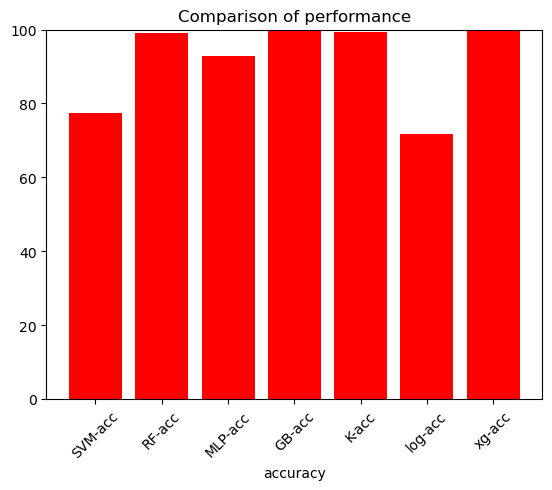

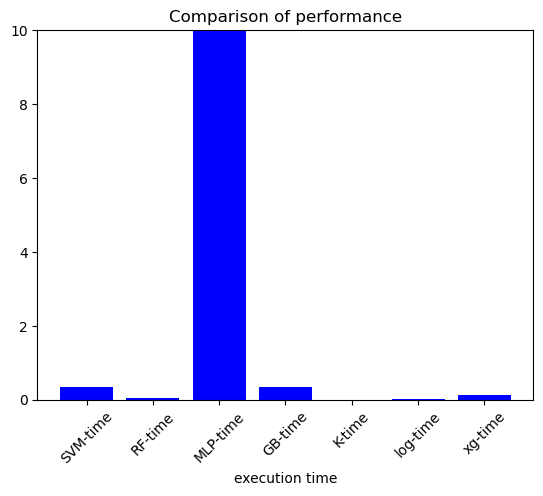

In [37]:
main()

In [42]:
def main1(preferred_method):
    if preferred_method == 'svm':
        svm_time, svm_accuracy = support_vector_machine()
    elif preferred_method == 'random_forest':
        rf_time, rf_accuracy = random_forest()
    elif preferred_method == 'mlp':
        mlp_time, mlp_accuracy = multilayer_perceptron()
    elif preferred_method == 'gradient_boosting':
        grad_time, grad_accuracy = gradient_boosting()
    elif preferred_method == 'k_neighbors':
        k_time, k_accuracy = k_neighbors()
    elif preferred_method == 'logistic_regression':
        log_time, log_accuracy = logistic_regression()
    elif preferred_method == 'xgboost':
        xg_time, xg_accuracy = xgboost()
    elif preferred_method == 'comparative':
        svm_time, svm_accuracy = support_vector_machine()
        rf_time, rf_accuracy = random_forest()
        mlp_time, mlp_accuracy = multilayer_perceptron()
        grad_time, grad_accuracy = gradient_boosting()
        k_time, k_accuracy = k_neighbors()
        log_time, log_accuracy = logistic_regression()
        xg_time, xg_accuracy = xgboost()

        accuracy = [svm_accuracy, rf_accuracy, mlp_accuracy, grad_accuracy,
                    k_accuracy, log_accuracy, xg_accuracy]
        time_ = [svm_time, rf_time, mlp_time, grad_time, k_time, log_time, xg_time]

        plt.ylim(0, 100)
        plt.xlabel("accuracy")
        plt.title("Comparison of performance")
        l1, l2, l3, l4, l5, l6, l8 = plt.bar(["SVM-acc", "RF-acc", "MLP-acc",
                                              "GB-acc", "K-acc", "log-acc",
                                              "xg-acc"],
                                             accuracy)

        plt.xticks(rotation=45)

        l1.set_facecolor('r')
        l2.set_facecolor('r')
        l3.set_facecolor('r')
        l4.set_facecolor('r')
        l5.set_facecolor('r')
        l6.set_facecolor('r')
        l8.set_facecolor('r')

        plt.show()
        plt.close('all')
        plt.ylim(0, 10)
        plt.xlabel("execution time")
        plt.title("Comparison of performance")
        c1, c2, c3, c4, c5, c6, c8 = plt.bar(["SVM-time", "RF-time", "MLP-time",
                                              "GB-time", "K-time", "log-time",
                                              "xg-time"],
                                             time_)
        c1.set_facecolor('b')
        c2.set_facecolor('b')
        c3.set_facecolor('b')
        c4.set_facecolor('b')
        c5.set_facecolor('b')
        c6.set_facecolor('b')
        c8.set_facecolor('b')
        plt.xticks(rotation=45)
        plt.show()

    else:
        print("None algorithm was given from input")



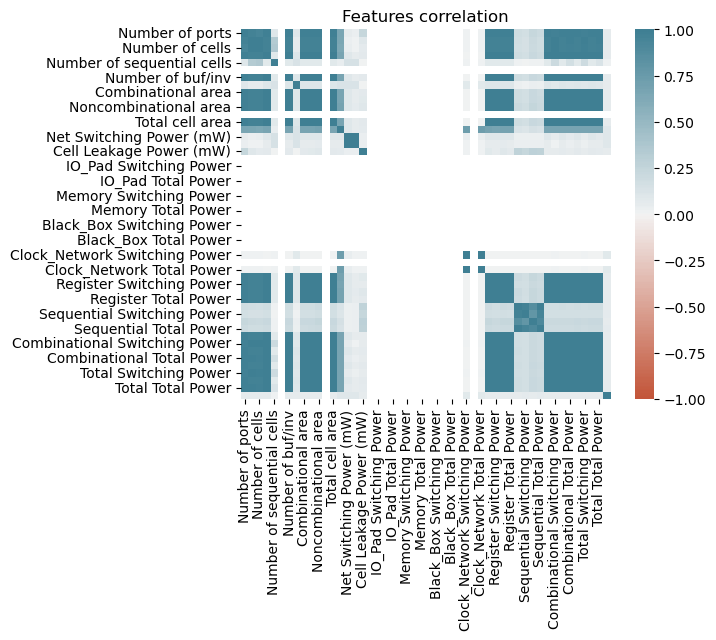

### GB ###

Training lasted 0.29 seconds
Accuracy = 99.56


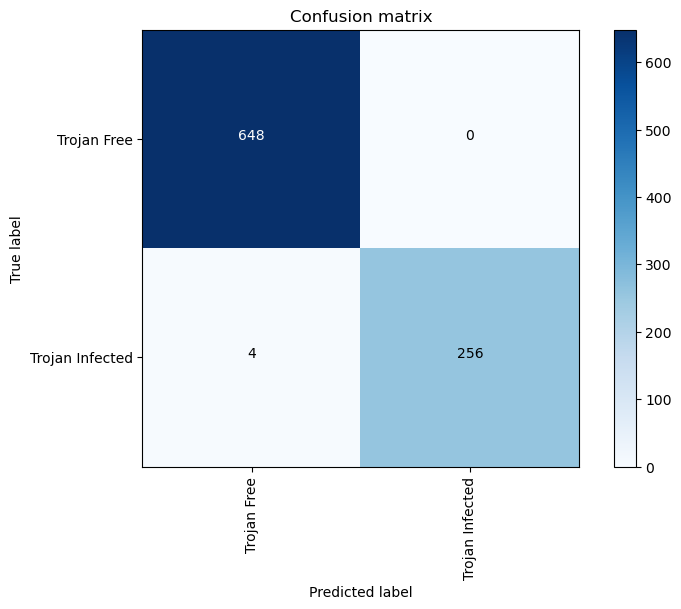

In [44]:
main1('gradient_boosting')